In [1]:
import numpy as np
from PIL import Image
from bs4 import BeautifulSoup
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [4]:
def read_batch(data): 


    Img = cv2.imread(data["image"])[...,::-1]  
    ann_map = cv2.imread(data["Mask"])[...,::-1]

    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) 
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)
    red_channel = ann_map[..., 0]

    _, binary_red = cv2.threshold(red_channel, 1, 255, cv2.THRESH_BINARY)
    plt.imshow(binary_red)
    plt.show()
    inds = np.unique(binary_red)[1:] 
    points= []
    masks = []
    for ind in inds:
        mask=(binary_red == ind).astype(np.uint8) 
        masks.append(mask)
        coords = np.argwhere(mask > 0) 
        yx = np.array(coords[np.random.randint(len(coords))]) 
        points.append([[yx[1], yx[0]]])
    return Img,np.array(masks),np.array(points), np.ones([len(masks),1])

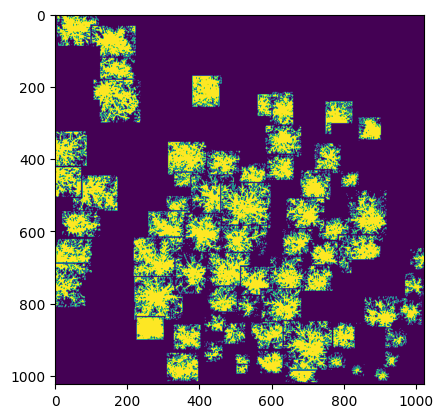

(array([[[142, 145, 144],
         [139, 141, 140],
         [148, 147, 147],
         ...,
         [148, 177, 174],
         [148, 173, 172],
         [144, 166, 166]],
 
        [[141, 146, 145],
         [136, 138, 137],
         [143, 143, 143],
         ...,
         [131, 158, 154],
         [137, 166, 161],
         [133, 162, 158]],
 
        [[133, 142, 138],
         [118, 123, 120],
         [130, 132, 130],
         ...,
         [126, 139, 136],
         [123, 143, 138],
         [121, 145, 139]],
 
        ...,
 
        [[181, 164, 176],
         [191, 173, 185],
         [179, 164, 174],
         ...,
         [114, 128, 125],
         [159, 174, 171],
         [174, 190, 187]],
 
        [[147, 126, 138],
         [157, 137, 149],
         [141, 123, 135],
         ...,
         [136, 150, 147],
         [167, 183, 180],
         [188, 204, 203]],
 
        [[102,  80,  95],
         [116,  95, 108],
         [114,  96, 107],
         ...,
         [164, 179, 178],
  

In [5]:
data = pd.read_csv("train_data.csv")
read_batch(data.iloc[0])

In [34]:
sam2_checkpoint = "checkpoints/sam2_hiera_small.pt" 
model_cfg = "sam2_hiera_s.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") 
predictor = SAM2ImagePredictor(sam2_model)


predictor.model.sam_mask_decoder.train(True) 
predictor.model.sam_prompt_encoder.train(True) 

predictor.model.image_encoder.train(True)

optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler() 


In [38]:
train_data = pd.read_csv("train_data.csv")
iou_values = []
for itr in range(100000):
    with torch.cuda.amp.autocast(): 
        i = np.random.choice(len(train_data))
        image,mask,input_point, input_label = read_batch(train_data.iloc[i]) 
    
        if mask.shape[0]==0: continue   
        predictor.set_image(image)

        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)

        batched_mode = unnorm_coords.shape[0] > 1 
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])


        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() 

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss=seg_loss+score_loss*0.05  


        predictor.model.zero_grad() 
        scaler.scale(loss).backward()  
        scaler.step(optimizer)
        scaler.update() 

        if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch");print("save model")


        if itr==0: mean_iou=0
        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
        iou_values.append(mean_iou)
        print("step)",itr, "Accuracy(IOU)=",mean_iou)

save model
step) 0 Accuracy(IOU)= 0.0001068444922566414
step) 2 Accuracy(IOU)= 0.00010641876068257262
step) 6 Accuracy(IOU)= 0.00018943891996619643
step) 8 Accuracy(IOU)= 0.00021419234252207243
step) 9 Accuracy(IOU)= 0.004370265345816518
step) 14 Accuracy(IOU)= 0.0044109507528536105
step) 18 Accuracy(IOU)= 0.0045982278547005515
step) 22 Accuracy(IOU)= 0.006013252426157742
step) 23 Accuracy(IOU)= 0.006081839960024402
step) 27 Accuracy(IOU)= 0.006070777208202669
step) 28 Accuracy(IOU)= 0.006012418513378901
step) 29 Accuracy(IOU)= 0.006089158988552877
step) 31 Accuracy(IOU)= 0.006082714886595321
step) 34 Accuracy(IOU)= 0.006261110607006367
step) 35 Accuracy(IOU)= 0.006286829644998941
step) 37 Accuracy(IOU)= 0.006311268919051114
step) 40 Accuracy(IOU)= 0.006471105820394575
step) 41 Accuracy(IOU)= 0.006584781442972471
step) 42 Accuracy(IOU)= 0.006525274812450098
step) 44 Accuracy(IOU)= 0.007490586074468877
step) 48 Accuracy(IOU)= 0.00745973608352702
step) 50 Accuracy(IOU)= 0.007518248970244

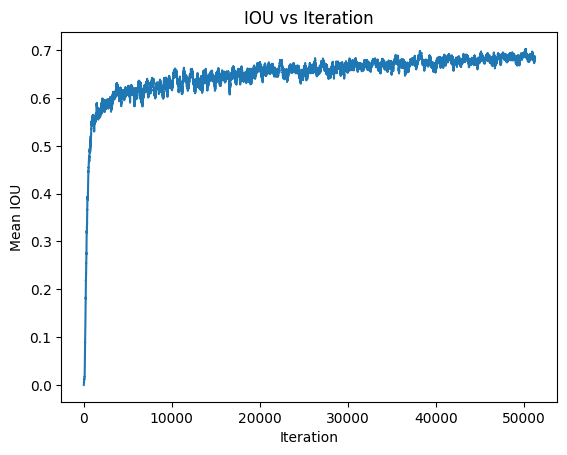

In [47]:
plt.plot(range(len(iou_values)), iou_values)
plt.xlabel("Iteration")
plt.ylabel("Mean IOU")
plt.title("IOU vs Iteration")
plt.show()